<a href="https://colab.research.google.com/github/nurniahamid/ML_Pemula/blob/main/%5BClustering%5D_Submission_Akhir_BMLP_Nurnia_Hamid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Perkenalan Dataset**

Sumber dataset : kaggle

Link Dataset : https://www.kaggle.com/datasets/sebastianwillmann/beverage-sales

Dataset menampilkan simulasi pola penjualan yang realistis di industri minuman, menyoroti faktor-faktor penting seperti preferensi regional, fluktuasi musiman, dan segmentasi pelanggan. Dataset ini menampilkan transaksi Business-to-Business (B2B) dan Business-to-Consumer (B2C), sehingga dapat diadaptasi untuk berbagai tujuan analitis

#Tujuan Project

Mengelompokkan pelanggan berdasarkan perilaku belanja mereka untuk memhami segmentasi pasar dan mendukung strategi bisnis seperti retensi, promosi dan penigkatan layanan.

# **2. Import Library**

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


# **3. Memuat Dataset**


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
df = pd.read_csv("/content/drive/MyDrive/Submission ML Pemula/Clustering/synthetic_beverage_sales_data.csv")
df.head()

,Order_ID,Customer_ID,Customer_Type,Product,Category,Unit_Price,Quantity,Discount,Total_Price,Region,Order_Date
0,ORD1,CUS1496,B2B,Vio Wasser,Water,1.66,53,0.10,79.18,Baden-Württemberg,2023-08-23
1,ORD1,CUS1496,B2B,Evian,Water,1.56,90,0.10,126.36,Baden-Württemberg,2023-08-23
2,ORD1,CUS1496,B2B,Sprite,Soft Drinks,1.17,73,0.05,81.14,Baden-Württemberg,2023-08-23
3,ORD1,CUS1496,B2B,Rauch Multivitamin,Juices,3.22,59,0.10,170.98,Baden-Württemberg,2023-08-23
4,ORD1,CUS1496,B2B,Gerolsteiner,Water,0.87,35,0.10,27.40,Baden-Württemberg,2023-08-23


# **4. Exploratory Data Analysis (EDA)**

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 11 columns):
 #   Column         Dtype  
---  ------         -----  
 0   Order_ID       object 
 1   Customer_ID    object 
 2   Customer_Type  object 
 3   Product        object 
 4   Category       object 
 5   Unit_Price     float64
 6   Quantity       int64  
 7   Discount       float64
 8   Total_Price    float64
 9   Region         object 
 10  Order_Date     object 
dtypes: float64(3), int64(1), object(7)
memory usage: 755.3+ MB


In [28]:
df.describe()

,Unit_Price,Quantity,Discount,Total_Price
count,8.999910e+06,8.999910e+06,8.999910e+06,8.999910e+06
mean,5.818037e+00,2.313813e+01,2.972879e-02,1.307437e+02
std,1.470050e+01,2.689321e+01,4.479841e-02,5.096947e+02
min,3.200000e-01,1.000000e+00,0.000000e+00,3.000000e-01
25%,1.050000e+00,6.000000e+00,0.000000e+00,8.400000e+00
50%,1.750000e+00,1.100000e+01,0.000000e+00,2.114000e+01
75%,3.210000e+00,3.000000e+01,5.000000e-02,6.949000e+01
max,1.695300e+02,1.000000e+02,1.500000e-01,1.429530e+04


In [29]:
df.duplicated().sum()

np.int64(0)

In [30]:
df.isnull().sum()

,0
Order_ID,0
Customer_ID,0
Customer_Type,0
Product,0
Category,0
Unit_Price,0
Quantity,0
Discount,0
Total_Price,0
Region,0


In [31]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8999910 entries, 0 to 8999909
Data columns (total 11 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Order_ID       object        
 1   Customer_ID    object        
 2   Customer_Type  object        
 3   Product        object        
 4   Category       object        
 5   Unit_Price     float64       
 6   Quantity       int64         
 7   Discount       float64       
 8   Total_Price    float64       
 9   Region         object        
 10  Order_Date     datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(6)
memory usage: 755.3+ MB


In [33]:
print('\nRingkasan Statistik:')
print(df[['Unit_Price','Discount', 'Quantity']].describe())


Ringkasan Statistik:
         Unit_Price      Discount      Quantity
count  8.999910e+06  8.999910e+06  8.999910e+06
mean   5.818037e+00  2.972879e-02  2.313813e+01
std    1.470050e+01  4.479841e-02  2.689321e+01
min    3.200000e-01  0.000000e+00  1.000000e+00
25%    1.050000e+00  0.000000e+00  6.000000e+00
50%    1.750000e+00  0.000000e+00  1.100000e+01
75%    3.210000e+00  5.000000e-02  3.000000e+01
max    1.695300e+02  1.500000e-01  1.000000e+02


# **5. Data Preprocessing**

In [34]:
#Agregasi data per Pelanggan
customer_features = df.groupby('Customer_ID').agg(
    Total_MonetaryValue=('Total_Price','sum'),
    Total_Quantity=('Quantity','sum'),
    Order_Frequency=('Order_ID', 'nunique'),
    Favorite_Category=('Category', lambda x: x.mode()[0] if not x.empty else None),
    favorite_Region=('Region', lambda x: x.mode()[0] if not x.empty else None),
    Customer_Type=('Customer_Type', 'first')
)

customer_features.head()

,Total_MonetaryValue,Total_Quantity,Order_Frequency,Favorite_Category,favorite_Region,Customer_Type
Customer_ID,,,,,,
CUS1,38904.13,7508,305,Soft Drinks,Mecklenburg-Vorpommern,B2C
CUS10,40288.83,6910,296,Water,Saarland,B2C
CUS100,36039.74,7163,287,Soft Drinks,Bayern,B2C
CUS1000,271186.90,44318,289,Soft Drinks,Thüringen,B2B
CUS10000,253436.72,46184,299,Juices,Sachsen,B2B


- Total_MonetaryValue = total uang yang dibelanjakan pelanggan
- Total_Quantity = total jumlah produk yang dibeli pelanggan
- Order_Freequency = kategory produk yang paling sering dibeli pelanggan
- Favorite_Region = Wilayah tempat pelanggan paling sering melakukan pemesanan
- Customer_type = Jenis pelanggan

In [35]:
customer_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, CUS1 to CUS9999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Total_MonetaryValue  10000 non-null  float64
 1   Total_Quantity       10000 non-null  int64  
 2   Order_Frequency      10000 non-null  int64  
 3   Favorite_Category    10000 non-null  object 
 4   favorite_Region      10000 non-null  object 
 5   Customer_Type        10000 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 546.9+ KB


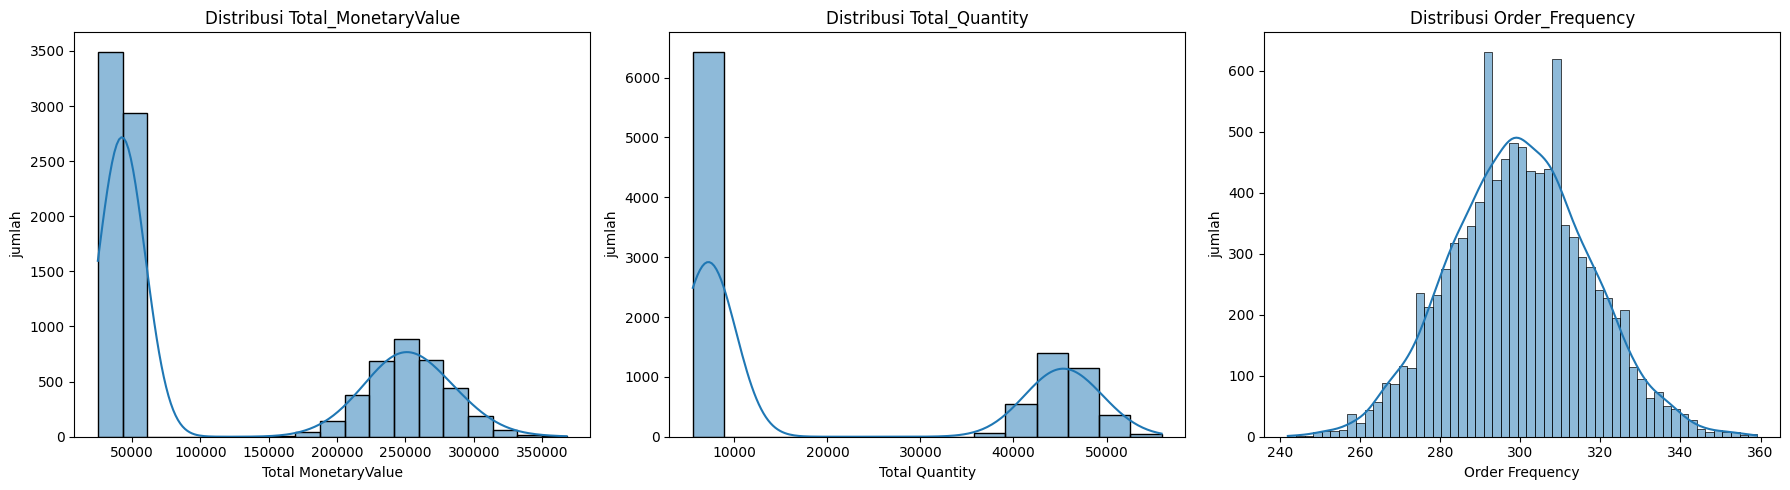

In [36]:
numerical_features = ['Total_MonetaryValue', 'Total_Quantity', 'Order_Frequency']

plt.figure(figsize=(18,5))
for i, feature in enumerate(numerical_features):
  plt.subplot(1, 3, i + 1)
  sns.histplot(customer_features[feature], kde=True)
  plt.title(f'Distribusi {feature}', fontsize=12)
  plt.xlabel(feature.replace('_',' '))
  plt.ylabel('jumlah')

plt.tight_layout()
plt.show()


Dari hasil distribusi numerik :
- Total_Quantity dan Total_MonetaryValue menunjukan distribusi bimodal yang kuat adanya dua kelompok utama pelanggan berdasarkan volume dan nilai belanja. ini menjadi saar yang baik untuk segmentasi
- Order_Frequency memiliki distribusi yang lebih normal ddan terpusat, mnunjukkan bahwa sebagian besar pelanggan memiliki frequency pemesana yang serupa, namun ttp waspada pada potensi outlier

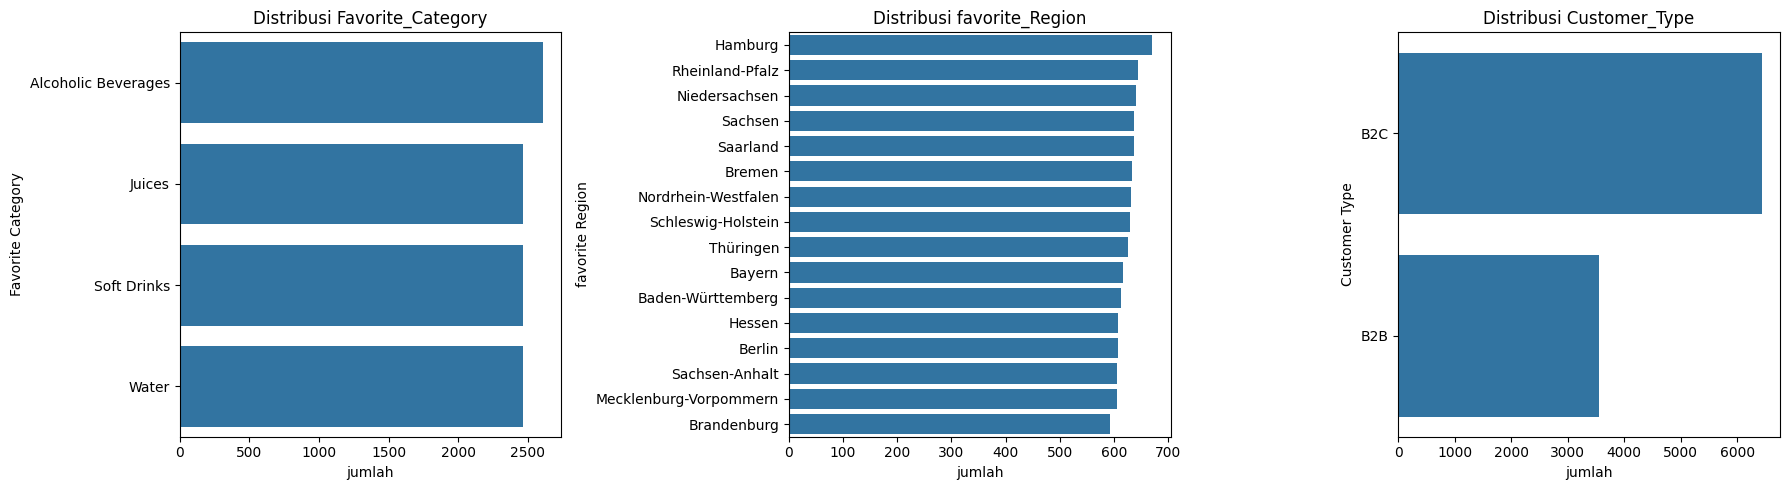

In [37]:
categorical_features = ['Favorite_Category', 'favorite_Region', 'Customer_Type']

plt.figure(figsize=(18,5))
for i, feature in enumerate(categorical_features):
  plt.subplot(1, 3, i + 1)
  sns.countplot(
      data=customer_features, y=feature,
      order=customer_features[feature].value_counts().index)
  plt.title(f'Distribusi {feature}', fontsize=12)
  plt.xlabel('jumlah')
  plt.ylabel(feature.replace('_',' '))

plt.tight_layout()
plt.show()

In [38]:
#Transformasi log buat fitur yang skewed
customer_features['Log_Total_MonetaryValue'] = np.log1p(customer_features['Total_MonetaryValue'])
customer_features['Log_Total_Quantity'] = np.log1p(customer_features['Total_Quantity'])

#buat normalisasi
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(
    customer_features[['Log_Total_MonetaryValue', 'Log_Total_Quantity', 'Order_Frequency']]
)

# **6. Pembangunan Model Clustering**

## **a. Pembangunan Model Clustering**

<function matplotlib.pyplot.show(close=None, block=None)>

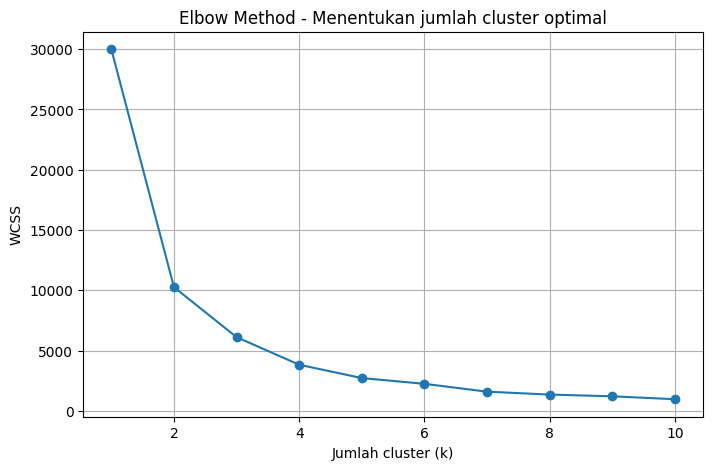

In [39]:
wcss =[]
for k in range (1, 11):
  kmeans = KMeans(n_clusters=k, random_state=42)
  kmeans.fit(numerical_data_scaled)
  wcss.append(kmeans.inertia_)

#buat plot elbow
plt.figure(figsize=(8,5))
plt.plot(range(1,11), wcss, marker='o')
plt.title('Elbow Method - Menentukan jumlah cluster optimal')
plt.xlabel('Jumlah cluster (k)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show

In [40]:
k_optimal = 4

kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
customer_features['Cluster_KMeans'] = kmeans_final.fit_predict(numerical_data_scaled)

## **b. Evaluasi Model Clustering**


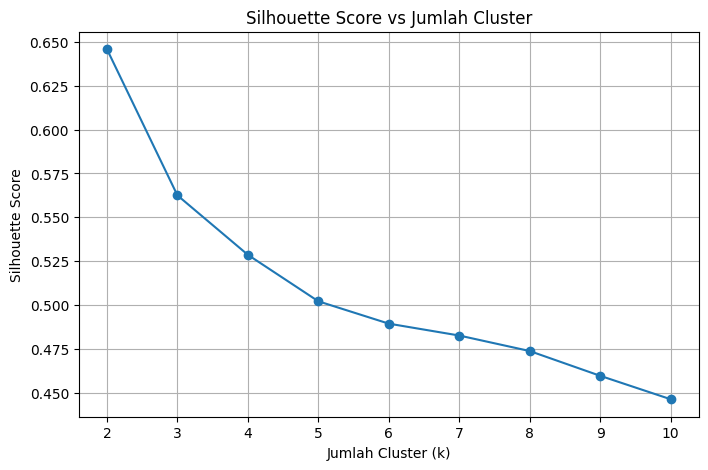

In [41]:
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(numerical_data_scaled)
    score = silhouette_score(numerical_data_scaled, labels)
    silhouette_scores.append(score)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs Jumlah Cluster')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [42]:
silhouette_k4 = silhouette_score(numerical_data_scaled, customer_features['Cluster_KMeans'])

print(f'Silhoutte Score untuk k=4: {silhouette_k4:.4f}')

Silhoutte Score untuk k=4: 0.5287


## **c. Visualisasi Hasil Clustering**

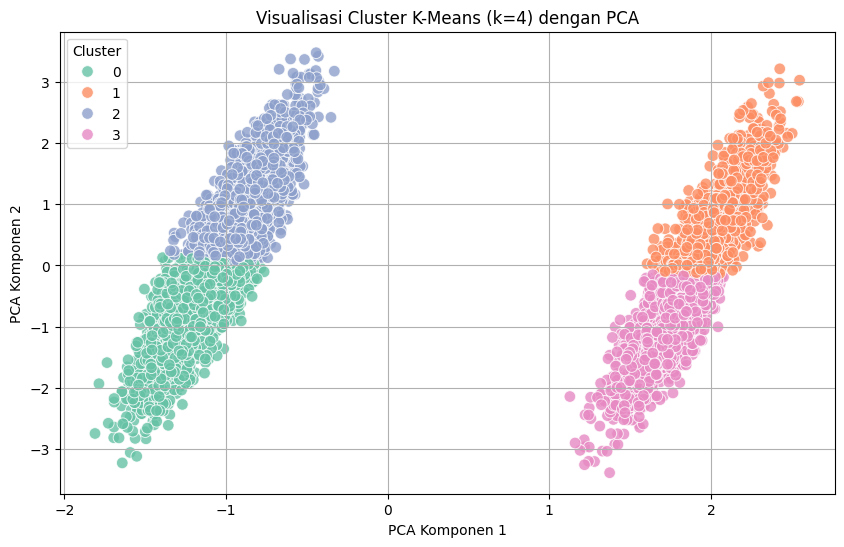

In [43]:
# Set jumlah cluster ke 4
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, random_state=42)
customer_features['Cluster_KMeans'] = kmeans_final.fit_predict(numerical_data_scaled)

# Lakukan PCA ke 2 komponen utama
pca = PCA(n_components=2)
pca_result = pca.fit_transform(numerical_data_scaled)

# Simpan hasil PCA ke dataframe
customer_features['PCA1'] = pca_result[:, 0]
customer_features['PCA2'] = pca_result[:, 1]

# Visualisasi Scatter Plot hasil clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=customer_features,
    x='PCA1', y='PCA2',
    hue='Cluster_KMeans',
    palette='Set2',
    s=70,
    alpha=0.8
)
plt.title('Visualisasi Cluster K-Means (k=4) dengan PCA')
plt.xlabel('PCA Komponen 1')
plt.ylabel('PCA Komponen 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()



## **e. Analisis dan Interpretasi Hasil Cluster**

In [44]:
# statsitik desktriptif dari tiap cluster

cluster_summary = customer_features.groupby('Cluster_KMeans').agg({
    'Total_MonetaryValue': ['mean', 'median'],
    'Total_Quantity': ['mean', 'median'],
    'Order_Frequency': ['mean', 'median'],
    'Favorite_Category': lambda x: x.mode()[0],
    'favorite_Region': lambda x: x.mode()[0],
    'Customer_Type': lambda x: x.mode()[0]
})

cluster_summary

Total_MonetaryValue             Total_Quantity           \
                              mean      median           mean   median   
Cluster_KMeans                                                           
0                     40634.387180   40504.465    6867.820352   6889.0   
1                    264332.877636  263728.120   47606.843549  47498.0   
2                     44783.787980   44735.330    7529.487857   7505.0   
3                    242603.996151  242408.720   43421.640000  43571.5   

               Order_Frequency           Favorite_Category  \
                          mean median             <lambda>   
Cluster_KMeans                                               
0                   286.081658  288.0               Juices   
1                   314.286632  312.0  Alcoholic Beverages   
2                   313.651399  311.0  Alcoholic Beverages   
3                   286.721622  289.0  Alcoholic Beverages   

                       favorite_Region Customer_Type  
                              <lambda>      <lambda>  
Cluster_KMeans                                        
0                      Rheinland-Pfalz           B2C  
1               Mecklenburg-Vorpommern           B2B  
2                              Sachsen           B2C  
3                            Thüringen           B2B

# Analisis Karakteristik Cluster dari Model KMeans

Berikut adalah analisis karakteristik untuk setiap cluster yang dihasilkan dari model KMeans.

## Cluster 0:
- **Monetary (rata-rata):** Rp.40.634
- **Quantity (rata-rata):** 6.868
- **Frequency (rata-rata):** 286
- **kategory Favorit:** Juices
- **Tipe pelanggan :** B2C
- **Interpretasi :** Pelanggan B2C dengan pembelian kecil-menengah baik dari sisi jumlah maupun nilai, dan frekuensi pemesanan moderat. Mereka cenderung loyal dengan preferensi ke produk Juices. Cocok untuk program loyalitas atau upselling.

## Cluster 1:
- **Monetary (Rata-rata):** Rp264.333
- **Quantity (Rata-rata):** 47.607
- **Frequency (Rata-rata):** 314
- **Kategori Favorit:** Alcoholic Beverages
- **Wilayah Favorit:** Mecklenburg-Vorpommern
- **Tipe Pelanggan:** B2B
- **Interpretasi:**
Pelanggan B2B dengan nilai transaksi tinggi, kuantitas besar, dan frekuensi pesanan tinggi. Ini adalah segmen premium dan prioritas — cocok untuk program retensi, diskon korporat, atau pelayanan khusus.


## Cluster 2:
- **Monetary (Rata-rata):** Rp44.784
-**Quantity (Rata-rata):** 7.529
-**Frequency (Rata-rata):** 314
-**Kategori Favorit:** Alcoholic Beverages
-**Wilayah Favorit:** Sachsen
-**Tipe Pelanggan:** B2C
-**Interpretasi:**
Pelanggan B2C yang sering melakukan pembelian (frekuensi tinggi), tapi nilai dan kuantitas belanja tergolong rendah. Ini bisa jadi pelanggan yang loyal tapi sensitif harga — cocok untuk promosi volume kecil atau bundling.

## Cluster 3:
-**Monetary (Rata-rata):** Rp242.604
-**Quantity (Rata-rata):** 43.422
-**Frequency (Rata-rata):** 287
-**Kategori Favorit:** Alcoholic Beverages
-**Wilayah Favorit:** Thüringen
-**Tipe Pelanggan:** B2B
-**Interpretasi:**
Mirip dengan Cluster 1, ini juga pelanggan B2B dengan nilai dan volume tinggi, tapi frekuensi sedikit lebih rendah. Masih segmen penting, mungkin pelanggan reguler dengan siklus pembelian lebih panjang.



In [45]:
customer_features.head()

,Total_MonetaryValue,Total_Quantity,Order_Frequency,Favorite_Category,favorite_Region,Customer_Type,Log_Total_MonetaryValue,Log_Total_Quantity,Cluster_KMeans,PCA1,PCA2
Customer_ID,,,,,,,,,,,
CUS1,38904.13,7508,305,Soft Drinks,Mecklenburg-Vorpommern,B2C,10.568881,8.923858,2,-1.050327,0.387273
CUS10,40288.83,6910,296,Water,Saarland,B2C,10.603854,8.840870,0,-1.135444,-0.128648
CUS100,36039.74,7163,287,Soft Drinks,Bayern,B2C,10.492405,8.876824,0,-1.245678,-0.642564
CUS1000,271186.90,44318,289,Soft Drinks,Thüringen,B2B,12.510567,10.699169,3,1.866801,-0.811476
CUS10000,253436.72,46184,299,Juices,Sachsen,B2B,12.442873,10.740410,3,1.897211,-0.232318


# **7. Mengeksport Data**

In [46]:
customer_features.to_csv('data_clustering_kmeans.csv', index=True)